In [1]:
# minimal
import numpy as np

# graphical
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd  # only for GA log dict plotting


# Only for ADC input
def to_hex(x, pos):
    return '0x%x' % int(x)

fmt = ticker.FuncFormatter(to_hex)


# Publication
plt.rcParams['figure.dpi'] = 100
plt.rcParams['axes.facecolor']='white'
plt.rcParams['figure.facecolor']='white'

plt.rcParams['savefig.facecolor']='white'

%matplotlib inline

# SIM ADC Input

In [2]:
import numpy as np

import random


ADC_bits = 12
ADC_smpls = 128

ADC_MAX  = 2**ADC_bits - 1
ADC_ZERO = 2**(ADC_bits-1) - 0
ADC_MIN = 0



def IsG(t, par):
    amp, tfast, tslow = par
    tslow = max(tfast*1.1, tslow)
    Islow = (np.exp(-t/tslow))
    Ifast = (1-np.exp(-t/tfast))
    # IsG = Ifast
    IsG = amp*(Islow + Ifast-1)
    return np.where(t < 0, 0, IsG) #IsG if t>0 else 0 



def SiPM_ADC():
    chrg = random.uniform(0.1,1)
    amp =  chrg * (ADC_MAX-ADC_ZERO) * 1.3
    par = [amp,4*random.uniform(0.6,1.5),14*chrg*random.uniform(0.2,1.4)]
    Dx = np.linspace(-1,ADC_smpls-2,ADC_smpls)
    Dy = IsG(Dx,par) + ADC_ZERO
    Dx = Dx - Dx[0]
    Dy = np.digitize(Dy, np.arange(1,ADC_MAX+1))
    return Dx, Dy

In [3]:
def DoubleSiPM_ADC():
    x,y = SiPM_ADC()
    xnew = np.random.randint(5,30)
    ynew = SiPM_ADC()[1]
    y[ xnew: ] += ynew[:len(x)-xnew] - + ADC_ZERO
    return x,y

In [4]:
def Nois(t, par):
    amp, tfast = par
    Ifast = (np.cos(-t/tfast))
    v = amp*(Ifast)
    return np.where(t < 0, 0, v) 


def Nois_ADC():
    chrg = random.uniform(0.8,1)
    amp =  chrg * (ADC_MAX*0.01)
    par = [amp,0.001*chrg*random.uniform(1.0,1.4)]
    Dx = np.linspace(-1,ADC_smpls-2,ADC_smpls)
    Dy = Nois(Dx,par) + ADC_ZERO
    Dx = Dx - Dx[0]
    Dy = np.digitize(Dy, np.arange(1,ADC_MAX+1))
    return Dx, Dy



In [5]:
def uint12_to_redint7(values, num_bits = 7):
    offset = np.clip( np.asarray(values, dtype=np.uint16) + 128 - ADC_ZERO ,0,ADC_MAX - ADC_ZERO)
    red = np.right_shift( offset,(12-num_bits-1))
    return red 



## Generic input simulation functions for 2 classes

In [6]:
def SiPM_inp():
    return uint12_to_redint7( SiPM_ADC()[1] )

# def Nois_inp():
#     return uint12_to_redint7( Nois_ADC()[1] )
def Nois_inp():
    return uint12_to_redint7( DoubleSiPM_ADC()[1] )

In [7]:
SiPM_lbl = "Good"
Nois_lbl = "Ugly" # "Double"



In [8]:
# for constraining/validating the network
def rand_inp():
    # return np.array(list(np.binary_repr(random.getrandbits( N ), width=N)), dtype=np.uint8) 
    # return SiPM_inp()
    return np.random.randint(low=uint12_to_redint7(ADC_ZERO), high=uint12_to_redint7(ADC_MAX), size=ADC_smpls)



In [9]:
lenTrain_D_good = 50
lenTrain_D_bad = 50


def distill_uniform(arr,min_amp=10,sample_size=100):
    arr = arr[np.max(arr, axis=1) >= min_amp]
    maxima = np.max(arr, axis=1)
    num_bins = 50
    bins = np.linspace(np.min(maxima), np.max(maxima), num_bins + 1)
    idx = np.digitize(maxima, bins) - 1
    counts = np.bincount(idx, minlength=num_bins)
    weights = 1.0 / counts[idx]
    weights /= np.sum(weights)  # normalize
    k = sample_size
    sample_indices = np.random.choice(range(len(arr)), size=k, p=weights)
    # sample = [arr[i] for i in sample_indices]


    # hist, bins = np.histogram(maxima, bins=len(arr))
    # probabilities = hist / np.sum(hist)
    # sampled_indices = np.random.choice(len(arr), size=sample_size, p=probabilities)
    # print(sample_indices[:10])
    return arr[sample_indices]


def gen_Data(good=lenTrain_D_good, bad=lenTrain_D_bad, min_amp = 10, ADC_smpls=ADC_smpls): # used to be dependent on NN[0], but = ADC_smpls
    Train_D_good = np.empty((good*20, ADC_smpls), dtype=np.uint8)
    for i in range(good*20):
        Train_D_good[i,:] = SiPM_inp()
    
    Train_D_bad = np.empty((bad*20, ADC_smpls), dtype=np.uint8)
    for i in range(bad*20):
        Train_D_bad[i,:] = Nois_inp()

    Train_D_good = distill_uniform(Train_D_good, min_amp = min_amp, sample_size = good)
    Train_D_bad  = distill_uniform(Train_D_bad,  min_amp = min_amp, sample_size = bad)
    # print(len(Train_D_good), len(Train_D_bad) )
    return Train_D_good, Train_D_bad



Train_D_good, Train_D_bad = gen_Data()

Train_D_good.shape, Train_D_bad.shape,

((50, 128), (50, 128))

In [10]:
SiPM_NNout = [1,0]
Nois_NNout = [0,1]


In [11]:
class_nr = {(0,1):0,(1,0):1,(1,1):2,(0,0):2}
[class_nr[tuple(i)] for i in [[0,1], [1,0], [1,1], [0,0]]]

def tuple_to_label(tuplist):
    p = np.asarray(tuplist)
    return np.where((p[:, 0] == 1) & (p[:, 1] == 0), 0, np.where((p[:, 0] == 0) & (p[:, 1] == 1), 1, 2))


SiPM_num_lbl, Nois_num_lbl = tuple_to_label([SiPM_NNout])[0], tuple_to_label([Nois_NNout])[0]

[SiPM_NNout, Nois_NNout, [1,1], [0,0]], tuple_to_label(  [SiPM_NNout, Nois_NNout, [1,1], [0,0]]  )

([[1, 0], [0, 1], [1, 1], [0, 0]], array([0, 1, 2, 2]))

# Define NN

In [12]:
# NN input paramters bit

# in bits
inp_len = 7
neur_len = 2
# bias_len = 2
# bias_len = 0
wght_len = 2

inp_max = np.uint16((1 << inp_len) - 1)


NN = (ADC_smpls, 16, 128, 2);
NN = np.array(NN)


keep_l = [None]*len(NN) # only needed at VHDL conversion step


In [13]:
NNdescr = "Good_vs_Double"

In [14]:
NNstr = NNdescr + " Net: " + "-".join(map(str,NN)) + f", (inp,neur,wght) bits: ({inp_len},{neur_len},{wght_len})"

NNstr

'Good_vs_Double Net: 128-16-128-2, (inp,neur,wght) bits: (7,2,2)'

In [15]:
NNfile = NNdescr + "_NN_" + "-".join(map(str,NN)) + f"__inp-neur-wght_bits__{inp_len}-{neur_len}-{wght_len}"
NNfile

'Good_vs_Double_NN_128-16-128-2__inp-neur-wght_bits__7-2-2'

# Make Indi

In [16]:
npSegm = np.cumsum( np.concatenate( [[0], NN[:-1]* NN[1:] * wght_len ]) )


def rand_indi_segmented(ps,NN=NN,npSegm=npSegm):
    arr = np.asarray(ps)
    if len(arr.shape) == 0:
        arr = np.asarray([ps])
    current_length = len(arr)
    target_length = len(NN)
    if current_length >= target_length:
        ps = arr[:target_length]
    else:
        last_element = arr[-1]
        extension = np.full(target_length - current_length, last_element)
        ps = np.concatenate([arr, extension])
    return np.concatenate( [  np.random.binomial(1, ps[s], size=(npSegm[s+1]-npSegm[s])) for s in range(len(NN)-1)  ] )

def rand_indi_custom(p):
    return rand_indi_segmented(p)

    
def rand_indi():
    return rand_indi_custom(0.85)

indi = rand_indi()



In [17]:
def conv_from_indi_to_wght(indi):
    arr =  np.array( indi ).astype(np.int8)
    wghtlist = [] 
    for i,s in enumerate( zip( npSegm [:len(NN)+1],  npSegm [1:len(NN)] ) ):
        # print(i,s)
        # iwght = arr[slice(*s)].reshape([2,max(NN[i+1], NN[i]),min(NN[i+1], NN[i])])
        iwght = arr[slice(*s)].reshape([NN[i+1], NN[i],2])
        # print(iwght)
        iwght_2bit = (iwght[:,:,0]) | (iwght[:,:,1] << 1)
        # print(iwght, iwght_2bit)
        wghtlist.append(iwght_2bit)
    return wghtlist

indi = rand_indi()


In [18]:
def conv_from_indi_to_summap(indi):
    summap = []
    for i in range(0,len(NN)-1):
        nonzwght = (NN[i] - np.uint8(conv_from_indi_to_wght(indi)[i] == 0).sum(axis = 1))
        # print(nonzwght)
        if i==0:
            summap.append( np.uint32( nonzwght[:,np.newaxis] * [0.25, 0.5, 0.75] * (uint12_to_redint7(ADC_MAX)-uint12_to_redint7(ADC_ZERO)) *1) )
        else:
            summap.append( np.uint32( nonzwght[:,np.newaxis] * [0.5, 1.5, 2.5]) )
    return summap

conv_from_indi_to_summap(indi)

[array([[ 3718,  7437, 11156],
        [ 3778,  7556, 11334],
        [ 3689,  7378, 11067],
        [ 3689,  7378, 11067],
        [ 3599,  7199, 10799],
        [ 3778,  7556, 11334],
        [ 3718,  7437, 11156],
        [ 3718,  7437, 11156],
        [ 3778,  7556, 11334],
        [ 3718,  7437, 11156],
        [ 3718,  7437, 11156],
        [ 3748,  7497, 11245],
        [ 3599,  7199, 10799],
        [ 3659,  7318, 10977],
        [ 3748,  7497, 11245],
        [ 3748,  7497, 11245]], dtype=uint32),
 array([[ 8, 24, 40],
        [ 8, 24, 40],
        [ 8, 24, 40],
        [ 8, 24, 40],
        [ 8, 24, 40],
        [ 8, 24, 40],
        [ 7, 22, 37],
        [ 7, 22, 37],
        [ 8, 24, 40],
        [ 8, 24, 40],
        [ 8, 24, 40],
        [ 7, 22, 37],
        [ 8, 24, 40],
        [ 7, 21, 35],
        [ 8, 24, 40],
        [ 8, 24, 40],
        [ 8, 24, 40],
        [ 8, 24, 40],
        [ 8, 24, 40],
        [ 8, 24, 40],
        [ 6, 19, 32],
        [ 8, 24, 40],
    

# Python NN Forward calc 

In [19]:
verbose = False


In [20]:

_CAM_LUT = np.array([ # with input 0, 1, 2 ,3
    0, 0, 0, 0,   # wght = 0, n = 0..3 => Block
    0, 1, 2, 3,   # wght = 1, n = 0..3 => Pass
    1, 2, 3, 3,   # wght = 2, n = 0..3 => Inc
    3, 2, 1, 0,   # wght = 3, n = 0..3 => Neg
], dtype=np.uint8)          # shape (16,)


def CAM_neur(neur: np.ndarray, wght: np.ndarray) -> np.ndarray: 
    # The index into the 4‑bit LUT is   idx = a*4 + b  == (a << 2) | b
    idx = (wght << 2) | neur          # still uint8, range 0‑15
    return _CAM_LUT[idx]            # vectorised lookup, result shape = (n_next,)


In [21]:
# dtype = np.uint16

def blk(inp):
    return np.zeros_like(inp)#, dtype=dtype)

def pas(inp):
    x = np.array(inp)#, dtype=dtype)
    return x

def inc(inp):
    x = np.array(inp)#, dtype=dtype)
    # return np.clip(x * 2, 0, 127)
    return np.minimum(x << 1, np.uint16((1 << inp_len ) - 1))

def neg(inp, bits=7):
    x = np.array(inp)
    tmp = np.bitwise_not(x)        # ~x
    # tmp = np.add(tmp, 1, dtype=dtype)             # ~x + 1
    result = np.bitwise_and(tmp, inp_max)   # (& mask)
    return result

case4 = {0: blk, 1: pas, 2: inc, 3: neg}
# case4 = {0: blk, 1: neg, 2: pas, 3: inc}


def CAM_inp_scalar(inp, wght):
    return case4[wght](inp)

CAM_inp = np.vectorize(CAM_inp_scalar)



### Calc Layer

In [22]:
import time

def layer_inp(input_i):
    # return np.uint8(input_i+1)
    return np.uint8(input_i)

def output_o(layer_nL):
    return (layer_nL>=2).astype(np.uint8)
    # bit0 = layer_nL & 1
    # bit1 = (layer_nL >> 1) & 1
    # # Interleave: [bit0[0], bit1[0], bit0[1], bit1[1], ...]
    # zipped = np.empty(bit0.size * 2, dtype=bit0.dtype)
    # zipped[0::2] = bit0
    # zipped[1::2] = bit1
    # return zipped



# d = None
def calc_layer(
    layer_pre: np.ndarray,
    layer_pre_idx: int,
    NNwgth: list[np.ndarray],
    NNsummap: list[np.ndarray],
) -> np.ndarray:
    """
    Compute the activations of the next layer in a simple feed-forward network.

    Returns
    -------
    np.ndarray, dtype uint8, shape (n_next,)
        The digitised activations of the next layer.
    """
    # ------------------------------------------------------------------ #
    weights = NNwgth[layer_pre_idx]

    if layer_pre_idx == 0:
        weighted = CAM_inp(layer_pre, weights)
    else:
        weighted = CAM_neur(layer_pre, weights)
    
    # ------------------------------------------------------------------ #
    neuron_sum = weighted.sum(axis=1)               # shape (n_next,)
    
    # ------------------------------------------------------------------ #
    bin_edges = NNsummap[layer_pre_idx]            # shape (n_next, n_bins)

    ReLu_2bit = np.fromiter(    (np.digitize(x, b) for x, b in zip(neuron_sum, bin_edges)),    dtype=np.uint8)
    
    neurons_next = ReLu_2bit
    
    return neurons_next
    


### Run NN: recursive layer calc

In [23]:
def run_NN(inp, pars, NN=NN):
    NNwgth,NNsummap  = pars
    layer_ni = layer_inp(inp)
    for i in range(0,len(NN)-1):
        layer_ni = calc_layer( layer_ni, i, NNwgth,  NNsummap)
    return output_o(layer_ni)



In [24]:
def run_NN_from_indi(data, indi, NN = NN):
    return np.apply_along_axis(func1d=run_NN, axis=1, arr=data, pars=(conv_from_indi_to_wght(indi), conv_from_indi_to_summap(indi)))




# Calc fitness

In [25]:
# def on_target(probe, target):
#     p = np.asarray(probe) # / np.sum(logits)   #softmax(logits)
#     t = np.asarray(target) # / np.sum(target)
#     # return np.sum(np.int8(np.all(p==t, axis=1)))
#     eq = np.equal(p,t)
#     # print(np.sum(eq))
#     return np.float16(np.sum(eq)/2)


In [26]:
def confusion_matrix(y_true, y_pred, n_classes=3):
    """
    Compute a plain (non‑normalized) confusion matrix.

    Parameters
    ----------
    y_true : array‑like, shape (n_samples,)
        Ground‑truth class indices (0 … n_classes‑1).
    y_pred : array‑like, shape (n_samples,)
        Predicted class indices (same coding as y_true).
    n_classes : int, optional (default=2)
        Number of distinct classes.

    Returns
    -------
    cm : ndarray, shape (n_classes, n_classes)
        cm[i, j] = # of samples whose true label = i and predicted label = j
        (rows = true, columns = predicted)
    """
    y_true = np.asarray(y_true, dtype=int)
    y_pred = np.asarray(y_pred, dtype=int)

    cm = np.zeros((n_classes, n_classes), dtype=int)

    # Efficient vectorised counting:
    #   for each possible pair (i, j) we count how many times it appears.
    for i in range(n_classes):
        for j in range(n_classes):
            cm[j, i] = np.sum((y_true == i) & (y_pred == j))

    return cm

cm = confusion_matrix([0,0,0,0,1,1,1,1],[0,0,0,0,1,0,1,1])
cm# [0,0], res_g[0:10],res_b[0:10],



array([[4, 1, 0],
       [0, 3, 0],
       [0, 0, 0]])

### def fitness

In [27]:
Train_D_good, Train_D_bad = gen_Data(100,100)

Train_D_good.shape, Train_D_bad.shape, 

((100, 128), (100, 128))

In [28]:
def fitness(indi, tests=10):
    res_g, res_b = run_NN_data_classes(indi, tests)
    acc = calc_accuracy(res_g, res_b)[0]
    div = diversity_score(res_g, res_b)
    return acc , div

def run_NN_data_classes(indi, tests=10):
    Train_D_good, Train_D_bad = gen_Data(tests, tests)

    res_g = run_NN_from_indi(Train_D_good, indi)

    res_b = run_NN_from_indi(Train_D_bad,  indi)
    return res_g, res_b




def calc_accuracy(res_g, res_b,res_rand=np.tile([1,1]     , (0 , 1))):
    # how_good = tuple_to_label(res_g) == SiPM_num_lbl
    # how_good = on_target(res_g, SiPM_NNout)
    # how_bad  = on_target(res_b, Nois_NNout)
    all_probes  = tuple_to_label( np.concatenate( [res_g, res_b, res_rand] ) )
    all_targets = tuple_to_label( np.concatenate( [
            np.tile(SiPM_NNout, (len(res_g) , 1)) , 
            np.tile(Nois_NNout, (len(res_b) , 1)) ,
            np.tile([1,1]     , (len(res_rand) , 1)) ,
        ]) )

    cm = confusion_matrix(all_probes,all_targets)
    return  (cm[0,0]+cm[1,1])/(len(res_g)+len(res_b)), cm

# def hit_percent(probe, target):
#     p = np.asarray(probe) # / np.sum(logits)   #softmax(logits)
#     t = np.asarray(target) # / np.sum(target)
#     eq = np.all(np.equal(p,t), axis=1)
#     # print(np.sum(eq))
#     return np.float32(np.sum(eq)/2)/len(p)#.shape[0]


def diversity_score(res_g, res_b):
    assert len(res_g)==len(res_b), f"{len(res_g)} {len(res_b)}"
    return np.sum(np.uint8(res_g != res_b)) / 2 / len(res_g)
    distmin = min(len(res_g),len(res_b))
    return np.sum(np.uint8(res_g[:distmin] != res_b[:distmin]))
    
    # return normalized_Shannon_entropy(tuple_to_label(np.concatenate( [res_g, res_b] )))


# def normalized_Shannon_entropy(arr, num_classes=3):
#     values, counts = np.unique(arr, return_counts=True)
#     probs = counts / counts.sum()
#     entropy = -np.sum(probs * np.log(probs)) / np.log(num_classes)
#     return entropy



# Setup GA

In [29]:
!pip install deap


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com


In [30]:
import random
from deap import base, creator, tools, algorithms


In [31]:
def selTournamentWithFitBracket(individuals, k, tournsize, max_fitness = None, min_fitness = None):
    pop = tools.selTournament(individuals, k, tournsize)
    # 2) Replace low-fitness winners
    sub_pop = [ind for ind in pop if (min_fitness and ind.fitness.values[0] < min_fitness) or (max_fitness and ind.fitness.values[0] > max_fitness)]
    return sub_pop


In [32]:
def eaSimpleWithElitism(population, toolbox, cxpb, mutpb, ngen, stats=None,
             halloffame=None, elites = 0, verbose=__debug__): # 

    logbook = tools.Logbook()
    logbook.header = ['gen', 'nevals'] + (stats.fields if stats else [])
    logbook.genlog = []

    # Evaluate the individuals with an invalid fitness
    invalid_ind = [ind for ind in population if not ind.fitness.valid]
    fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
    for ind, fit in zip(invalid_ind, fitnesses):
        ind.fitness.values = fit

    if halloffame is not None:
        halloffame.update(population)
    if len(halloffame) < elites:
        elites = len(halloffame)

    record = stats.compile(population) if stats else {}
    logbook.record(gen=0, nevals=len(invalid_ind), **record)
    if verbose:
        print(logbook.stream)

    # Begin the generational process
    for gen in range(1, ngen + 1):
        try:
            # Select the next generation individuals
            offspring = toolbox.select(population, int(len(population)*1.01))
        
            # Vary the pool of individuals
            offspring = algorithms.varAnd(offspring, toolbox, cxpb, mutpb)
            if len(population) > len(offspring):
                fillers = algorithms.varAnd(offspring[:], toolbox, cxpb, mutpb)[:len(population)-len(offspring)]
                offspring.extend(fillers)
            if elites>0:
                old_best_idx = tools.selBest(population, elites)
                for best_i in old_best_idx:
                    del best_i.fitness.values
                offspring.extend(old_best_idx)
    
    
            # Evaluate the individuals with an invalid fitness
            # for ind in halloffame.items[:elites]:
            #     ind.fitness.valid = False
            invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
            fitnesses = toolbox.map(toolbox.evaluate, invalid_ind)
            for ind, fit in zip(invalid_ind, fitnesses):
                ind.fitness.values = fit
    
            # Update the hall of fame with the generated individuals
            if halloffame is not None:
                halloffame.update(offspring)

            
            # if elites > 0:
            #     # best = population
            #     offspring = offspring[:-elites]
            #     offspring.extend(halloffame.items[:elites])
            
            # Replace the current population by the offspring, remove worst if too long e.g. due to elitism
            if len(offspring)>len(population):
                worst_idx = tools.selWorst(offspring, len(offspring)-len(population))
                for worst_one in worst_idx: 
                    offspring.remove(worst_one)
           
            population[:] = offspring[:]
            
            # if elites > 0 and elites <= len(population) and elites <= len(hof):
            #     population[-elites:] = halloffame[:]
    
            # Append the current generation statistics to the logbook
            record = stats.compile(population) if stats else {}
            # max_f = record['fitness']['max']
            # avg_f = record['fitness']['avg']
            logbook.record(gen=gen, nevals=len(invalid_ind), **record)
            logbook.genlog.append(tools.selBest(population, 1)[0])
            if verbose:
                print(logbook.stream)
        except Exception as e:
            print(f"Interrupted by {e}; current gen: {gen}")

    return population, logbook

In [33]:
def eval_size(individual):
    zero_genes = np.sum( [len(np.where( np.ravel( i )==0)[0]) for i in conv_from_indi_to_wght(individual)] )
    return zero_genes  / ( len(individual)/2)


In [41]:
import time
from dateutil.relativedelta import relativedelta
time.time()

import multiprocessing
pool = multiprocessing.Pool(12)


# --- Constants ---
GENOME_LENGTH = npSegm[-1]
POP_SIZE = 300 #1000
CXPB = 0.5  # Crossover probability
MUTPB = 5 / GENOME_LENGTH  # Mutation probability per bit
NGEN = 10 #100  # Number of generations
TOURN_SIZE = 3
ELITE_SIZE = 1  #0  #2
HOF_SIZE = 3 # NGEN
FIT_TESTS = 50
FIT_TYPICAL = np.median([fitness(rand_indi_custom(0.5)) for i in range(3)])


POP_SIZE += ELITE_SIZE

In [42]:
# --- Evaluation Function ---
def evaluate(individual):
    fit, div = fitness(individual, FIT_TESTS)
    siz = eval_size(individual)
    # return  fit, div, siz
    # return  fit*((div+0.5)/1.5), siz
    return  fit*div, fit, siz



In [43]:
# indi = rand_indi()
# %load_ext line_profiler
# %lprun -f evaluate evaluate(rand_indi()) 
# Total time: 10.2548 s
# %lprun -f fitness fitness(rand_indi(), FIT_TESTS) 
# Total time: 10.1448 s
# %lprun -f run_NN_data_classes run_NN_data_classes(rand_indi(), FIT_TESTS) 
# Total time: 10.0497 s
# %lprun -f run_NN_from_indi run_NN_from_indi(gen_Data(FIT_TESTS,FIT_TESTS)[0], rand_indi()) 
#Total time: 5.07403 s
# %lprun -f run_NN run_NN(gen_Data(FIT_TESTS,FIT_TESTS)[0][0], pars=(conv_from_indi_to_wght(indi), conv_from_indi_to_summap(indi)))
# Total time: 0.0564802 s


In [44]:
time_start = time.time()

def time_elapsed(pop):
    time_diff = time.time() - time_start # seconds
    rd = relativedelta(seconds=time_diff)
    years = f'{int(rd.years)} y, ' if rd.years > 0 else ''
    months = f' {int(rd.months)} mon, ' if rd.months > 0 else ''
    days = f' {int(rd.days)} d' if rd.days > 0 else ''
    hours = f' {int(rd.hours)} h' if rd.hours > 0 else ''
    mins = f' {int(rd.minutes)} m' if rd.minutes > 0 else ''
    secs = f' {int(rd.seconds)} s' if rd.seconds > 0 else ''
    t =  f'{years}{months}{days}{hours}{mins}{secs}'
    return t.rjust(15)
    # return repr(rd)
    # return time_diff

def diversity(pop):
    """Return the fraction of unique fitnesses in the population."""
    unique = len({ind for ind in pop})
    return unique / len(pop)


# def first_indi(pop):
#     for i in pop:
#         return "".join(str(i))

# --- Fitness and Individual ---
if "creator" in globals():
    if hasattr(creator, "FitnessMaxSmall"):
        del creator.FitnessMaxSmall
    if hasattr(creator, "FitnessMin"):
        del creator.FitnessMin
    if hasattr(creator, "FitnessMax"):
        del creator.FitnessMax
    if hasattr(creator, "Individual"):
        del creator.Individual

# creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
# creator.create("Individual", list, fitness=creator.FitnessMin)
# creator.create("FitnessMax", base.Fitness, weights=(1.0,))
# creator.create("Individual", list, fitness=creator.FitnessMax)

# creator.create("FitnessMaxSmall", base.Fitness, weights=(1.0,0.2,0.1))
creator.create("FitnessMaxSmall", base.Fitness, weights=(10.0, 1.0, 0.1))
creator.create("Individual", list, fitness=creator.FitnessMaxSmall)

# --- Toolbox Setup ---
toolbox = base.Toolbox()
# toolbox.register("attr_bool", random.randint, 0, 1)
toolbox.register("attr_bool", np.random.binomial, 1, 0.8)
# toolbox.register("attr_bool", np.random.binomial, 1, 0.25)

def rand_indi_prod():
    return rand_indi_segmented( [0.57,0.85] )

toolbox.register("attr_bool_segmented", rand_indi_prod)


# toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, GENOME_LENGTH)
# toolbox.register("individual", tools.initCycle, creator.Individual, 
#                  (toolbox.attr_bool_bnml_hi, toolbox.attr_bool_bnml_lo), 
#                  n=GENOME_LENGTH//2
#                 )


toolbox.register("proto", tools.initRepeat, creator.Individual, toolbox.attr_bool, GENOME_LENGTH)

def individual_with_retries(generator, fitness_func, typ_fitness, retries=7):
    best_ind = None
    best_fit = float("inf")
    for i in range(retries + 1):
        ind = generator() #toolbox.proto()
        fit = fitness_func(ind) 
        if fit < best_fit:
            best_fit = fit
            best_ind = ind
            best_ind.fitness.values = (fit,0)
        # if best_fit >= min_fitness:
        if best_fit != typ_fitness:
            print(f"{fit:g} ", end='' )
            break
    return best_ind

# toolbox.register("individual", individual_with_retries, toolbox.proto, fitness, typ_fitness=FIT_TYPICAL, retries=7)



toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.attr_bool_segmented)



toolbox.register("population", tools.initRepeat, list, toolbox.individual)


toolbox.register("evaluate", evaluate)

toolbox.register("mate", tools.cxUniform, indpb=0.5)
# toolbox.register("mate", tools.cxTwoPoint)

toolbox.register("mutate", tools.mutFlipBit, indpb=MUTPB)
toolbox.register("select", tools.selTournament, tournsize=TOURN_SIZE) 
# toolbox.register("select", selTournamentWithFitBracket, tournsize=3, toolbox=toolbox, max_fitness = 0.99) 
# toolbox.register("select", selTournamentWithFitBracket, tournsize=3, min_fitness = 1.001) 

# toolbox.register("select", tools.selNSGA2) 


# --- Main GA Loop ---
def main(pre_pop=None):
    print("Create init population...")
    time_start = time.time()
    print(type(toolbox.population(n=POP_SIZE)[0]))
    if not pre_pop:
        pop = toolbox.population(n=POP_SIZE)
    else:
        # if type(pre_pop) == 'list' :
        print("found pre_pop")
        pre_pop_best=3
        rep = (POP_SIZE // pre_pop_best)+1
        pop = np.repeat( tools.selBest(pre_pop, pre_pop_best) ,POP_SIZE//pre_pop_best+1 , axis=0 )[:POP_SIZE]
        print(type(pop), type(pop[0]),len(pop),len(pop[0]) )
        for indi in pop:
            toolbox.mutate(indi)
        print(type(pop), type(pop[0]),len(pop),len(pop[0]) )
        pop = [creator.Individual(raw_list) for raw_list in pop]
 
        # pop = [toolbox.clone(ind) for ind in pop]
        print(type(pop), type(pop[0]),len(pop),len(pop[0]) )

    
    hof = tools.HallOfFame(HOF_SIZE)
    stats = tools.Statistics(lambda ind: ind.fitness.values[0])
    stats.register("max",  lambda x: round(max(x), 4))#max)
    stats.register("avg",  lambda x: round(np.mean(x), 3))
    stats.register("min",  lambda x: round(min(x), 4))#min)
    stats.register("diversity", lambda x: round(diversity(x), 3)) 
    # stats.register("first_indi", first_indi)
    stats.register("time", time_elapsed)

    # For second objective
    stats2 = tools.Statistics(lambda ind: ind.fitness.values[1])
    stats2.register("max",  lambda x: round(max(x), 3))
    # stats2.register("avg",  lambda x: round(np.mean(x), 3))
    # stats2.register("min",  lambda x: round(min(x), 3))
    
    # For third objective
    stats3 = tools.Statistics(lambda ind: ind.fitness.values[2])
    stats3.register("max",  lambda x: round(max(x), 3))
    # stats3.register("avg",  lambda x: round(np.mean(x), 3))
    # stats3.register("min",  lambda x: round(min(x), 3))
    
    # Combine
    mstats = tools.MultiStatistics(fitness=stats, divers=stats2, size=stats3)
    # mstats = tools.MultiStatistics(fitness=stats, size=stats2)
    print( time_elapsed(None) )
    time_start = time.time()


    print(f"Start Algorithm, run for {NGEN} generations...")
    print(f"    cxpb={CXPB}, mutpb/genome={MUTPB*GENOME_LENGTH}, tournsize={TOURN_SIZE}, elites={ELITE_SIZE}, typical fitness = {FIT_TYPICAL:g}  ")

    pop, log =  eaSimpleWithElitism(  
    # pop, log = algorithms.eaSimple(
        pop, toolbox,
        cxpb=CXPB, 
        mutpb=1.0,  # mutpb=1.0 means each individual is mutated with MUTPB per bit
        ngen=NGEN,
        stats=mstats,
        halloffame=hof,
        elites=ELITE_SIZE,
        verbose=True
    )

    # algorithms.eaGenerateUpdate(toolbox, ngen=150, stats=stats, halloffame=hof)
    # pop, log = algorithms.eaGenerateUpdate(
    #     pop, toolbox,
    #     ngen=NGEN, 
    #     # evaluate=toolbox.parallel_evaluate,
    #     stats=stats, 
    #     halloffame=hof, 
    #     cxpb=CXPB, 
    #     mutpb=MUTPB,
    #     verbose=True
    # )

    
    return pop, log, hof
# if __name__ == "__main__":
    # main()

## run GA

In [45]:

if "pop" in globals():
    del pop
if "log" in globals():
    del log
if "hof" in globals():
    del hof

toolbox.register("map", pool.map)

pop, log, hof = main()
# pop, log, hof = main(log_read.genlog)



# import datetime
# import pickle

# now_timestamp_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# # NN_descr = "-".join( [str(i) for i in NN] ) + f"__bitlen_neur-wght-bias_{neur_len}-{wght_len}-{bias_len}"
# filename = f"{now_timestamp_str}_log__{NNfile}.pkl"

# with open(filename, 'wb') as file:
#     pickle.dump(log, file)


Create init population...
<class 'deap.creator.Individual'>
            2 s
Start Algorithm, run for 10 generations...
    cxpb=0.5, mutpb/genome=5.0, tournsize=3, elites=1, typical fitness = 0  
   	      	        divers        	                                fitness                                	         size         
   	      	----------------------	-----------------------------------------------------------------------	----------------------
gen	nevals	gen	max	nevals	avg  	diversity	gen	max   	min	nevals	time           	gen	max  	nevals
0  	301   	0  	0.5	301   	0.028	0.654    	0  	0.1104	0  	301   	           41 s	0  	0.113	301   
1  	305   	1  	0.5	305   	0.038	0.688    	1  	0.1156	0  	305   	       1 m 13 s	1  	0.109	305   
2  	305   	2  	0.5	305   	0.048	0.714    	2  	0.1189	0  	305   	       1 m 43 s	2  	0.111	305   
3  	305   	3  	0.5	305   	0.056	0.724    	3  	0.1372	0  	305   	       2 m 14 s	3  	0.113	305   
4  	305   	4  	0.5	305   	0.061	0.701    	4  	0.1715	0  	305 

In [46]:
import datetime
import pickle

now_timestamp_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

# NN_descr = "-".join( [str(i) for i in NN] ) + f"__bitlen_neur-wght-bias_{neur_len}-{wght_len}-{bias_len}"
filename = f"{now_timestamp_str}_log__{NNfile}.pkl"

log.hof = hof

with open(filename, 'wb') as file:
    pickle.dump(log, file)


In [47]:
!ls -lart *.pkl | tail -n3 


-rwxr-xr-x. 1 i.bekman domänen-benutzer 19565292 Oct 10 13:34 20251010_133451_log__Good_vs_Double_NN_128-16-128-2__inp-neur-wght_bits__7-2-2.pkl
-rwxr-xr-x. 1 i.bekman domänen-benutzer 19756910 Oct 11 14:19 20251011_141932_log__Good_vs_Double_NN_128-16-128-2__inp-neur-wght_bits__7-2-2.pkl
-rwxr-xr-x. 1 i.bekman domänen-benutzer  1727478 Oct 14 23:12 20251014_231239_log__Good_vs_Double_NN_128-16-128-2__inp-neur-wght_bits__7-2-2.pkl


# Observe result

In [48]:
indi = hof[0]
indi = tools.selBest(log.genlog,1)[0]


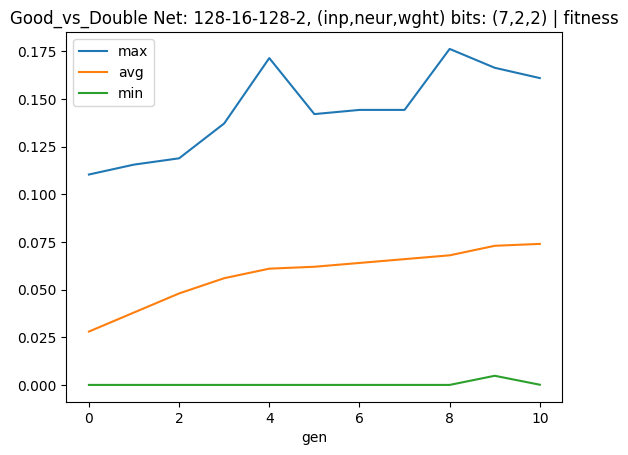

In [49]:
pd.DataFrame(log.chapters['fitness']).plot("gen", ["max","avg","min"])
plt.title(NNstr + " | fitness")

import datetime

now_timestamp_str = datetime.datetime.now().strftime("%Y%m%d_%H%M%S")
filename = f"{now_timestamp_str}_fitness_vs_gen__{NNfile}.png"
# plt.gcf().savefig(filename, dpi=100)

Text(0.5, 1.0, 'Good_vs_Double Net: 128-16-128-2, (inp,neur,wght) bits: (7,2,2) | size')

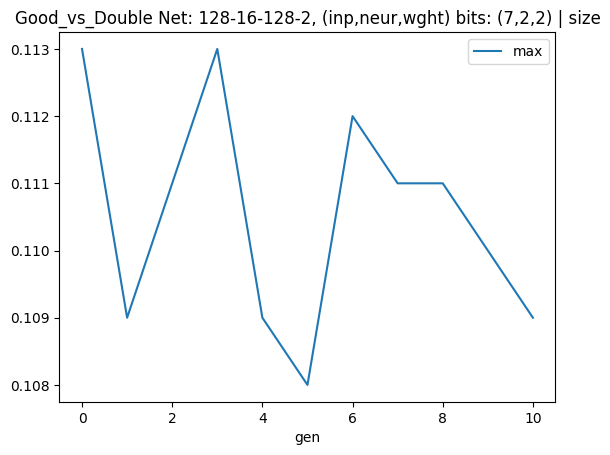

In [50]:
pd.DataFrame(log.chapters['size']).plot("gen", ["max"])#,"avg","min"])
plt.title(NNstr + " | size")

In [51]:
bins = np.linspace(0,1,21)

In [52]:
indi = log.genlog[-1]

verbose = False
if indi is not None:
    Train_D_good, Train_D_bad = gen_Data(int(5000),int(5000))

    res_g = run_NN_from_indi(Train_D_good, indi)
    # res_g = np.apply_along_axis(func1d=run_NN, axis=1, arr=Train_D_good, pars=(conv_from_indi_to_wght(indi),conv_from_indi_to_summap(indi) ))
    # plt.hist( (np.float32(np.sum( res , axis=1))) , alpha=0.5,   label="Good")
    
    res_b = run_NN_from_indi(Train_D_bad, indi)
    # res_b = np.apply_along_axis(func1d=run_NN, axis=1, arr=Train_D_bad, pars=(conv_from_indi_to_wght(indi), conv_from_indi_to_summap(indi)))
    # return good + bad


In [53]:
res_rand = run_NN_from_indi([rand_inp() for i in range(1000)], indi)
rand = [fitness(rand_indi())[0] for i in range(10)]

Text(0.5, 1.0, 'Good_vs_Double Net: 128-16-128-2, (inp,neur,wght) bits: (7,2,2) with Training data')

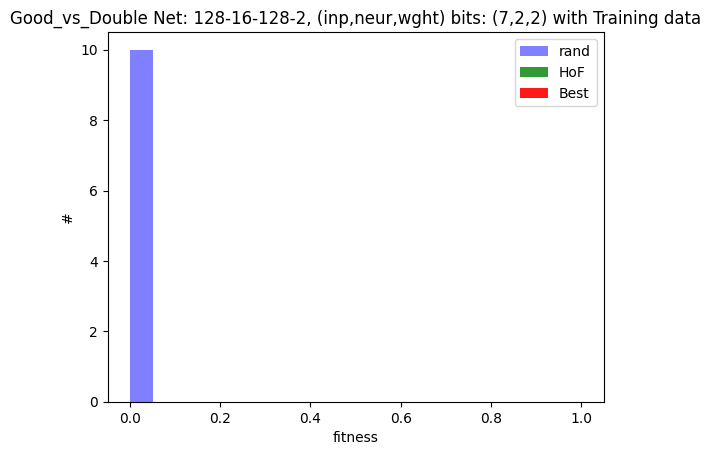

In [54]:
bins = np.linspace(0,1,21)
plt.hist( rand                                                  ,bins=bins , alpha=0.5, color='blue' ,  label="rand")
plt.hist([hof[i].fitness.wvalues[0] for i in range(1,min(10,len(hof)))] ,bins=bins , alpha=0.8, color='green',  label="HoF")
plt.hist([hof[0].fitness.wvalues[0]]                            ,bins=bins , alpha=0.9, color='red'  ,  label="Best")
# plt.hist([test_fitness(rand_indi_custom(0.9)) for i in range(100)] ,bins=bins , alpha=0.5,     label="rand(0.9)")


plt.legend()
plt.xlabel("fitness")
plt.ylabel("#")
plt.title(NNstr + " with Training data")


## Show confusion_matrix

11000 11000


array([[3148, 2983,    0],
       [1166,  644,    0],
       [ 686, 1373, 1000]])

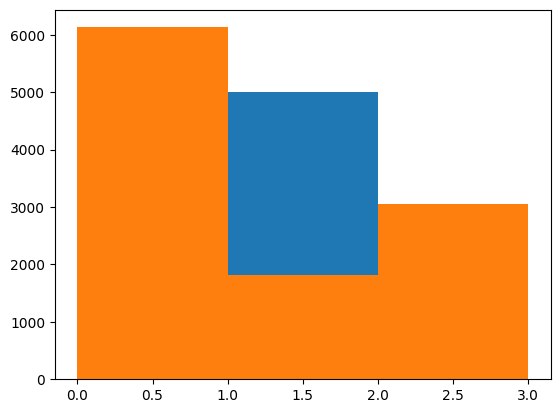

In [55]:


res = tuple_to_label( np.concatenate([res_g,res_b,res_rand]) )
tru = tuple_to_label( np.concatenate([[[1,0]]*len(res_g),[[0,1]]*len(res_b),[[1,1]]*len(res_rand)]) )
print(len(res), len(tru),  )
plt.hist(tru, bins=range(4))
plt.hist(res, bins=range(4))

cm = confusion_matrix(tru,res)
cm# [0,0], res_g[0:10],res_b[0:10],

(5000, 5000)

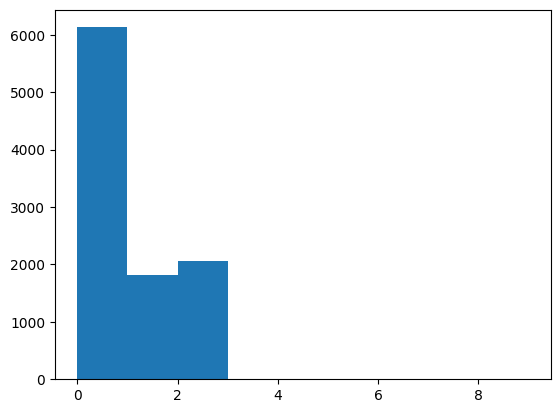

In [56]:
plt.hist(tuple_to_label( np.concatenate([res_g,res_b]) ), bins=range(10))

len(Train_D_bad), len(Train_D_good),


[[3148 2983    0]
 [1166  644    0]
 [ 686 1373 1000]]
0 0 3148 Text(0.0, 0.0, '3148')
0 1 2983 Text(0.0, 1.0, '2983')
0 2 0 Text(0.0, 2.0, '0')
1 0 1166 Text(1.0, 0.0, '1166')
1 1 644 Text(1.0, 1.0, '644')
1 2 0 Text(1.0, 2.0, '0')
2 0 686 Text(2.0, 0.0, '686')
2 1 1373 Text(2.0, 1.0, '1373')
2 2 1000 Text(2.0, 2.0, '1000')


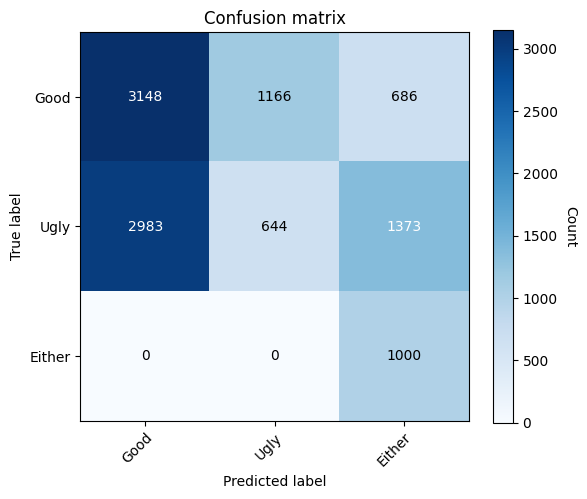

In [57]:
def plot_confusion_matrix(cm,
                          class_names=["Good","Bad","Either"],
                          title='Confusion matrix',
                          cmap='Blues',
                          normalize=False,
                          figsize=(6, 5)):
    """
    Draw a confusion matrix with Matplotlib.

    Parameters
    ----------
    cm : ndarray, shape (n_classes, n_classes)
        The confusion matrix (raw counts or already normalized).
    class_names : list of str, optional
        Human readable names for each class.  If None, uses 0,1,… .
    title : str, optional
    cmap : str or Colormap, optional
        Colormap used for the heat‑map.
    normalize : bool, optional
        If True, each row is normalized to sum to 1 (i.e. per‑class recall).
    figsize : tuple, optional
    """
    if class_names is None:
        class_names = [str(i) for i in range(cm.shape[0])]

    if normalize:
        # Avoid division by zero
        row_sums = cm.sum(axis=1, keepdims=True)
        cm_disp = np.divide(cm, row_sums, where=row_sums != 0)
    else:
        cm_disp = cm

    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(cm_disp.T, interpolation='nearest', cmap=cmap)

    # Color‑bar
    cbar = ax.figure.colorbar(im, ax=ax)
    cbar.ax.set_ylabel('Normalized fraction' if normalize else 'Count',
                       rotation=-90, va="bottom")

    # Tick marks + labels
    ax.set(
        xticks=np.arange(cm.shape[1]),
        yticks=np.arange(cm.shape[0]),
        xticklabels=class_names,
        yticklabels=class_names,
        ylabel='True label',
        xlabel='Predicted label',
        title=title
    )

    # Rotate the x‑tick labels for readability
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Annotate each cell with the numeric value
    thresh = cm_disp.max() / 2.0/1.2
    fmt = '.2f' if normalize else 'd'
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            val = cm_disp[i, j]
            col = "white" if val > thresh else "black"
            r = ax.text(float(i), float(j), format(val, fmt),
                    ha="center", va="center",
                    color=col)
            print(i,j,format(val, fmt),r)

    fig.tight_layout()
    plt.show()

print(cm)
plot_confusion_matrix(cm, class_names=[SiPM_lbl,Nois_lbl,"Either"],)

In [58]:
cm = confusion_matrix(tuple_to_label( run_NN_from_indi([rand_inp() for i in range(1000)], rand_indi()))  ,[2])
cm


array([[   0,    0,    0],
       [   0,    0,    0],
       [   0,    0, 1000]])

In [59]:
cm = confusion_matrix(tuple_to_label( run_NN_from_indi([rand_inp() for i in range(1000)], indi))  ,[2])
cm


array([[   0,    0,    0],
       [   0,    0,    0],
       [   0,    0, 1000]])

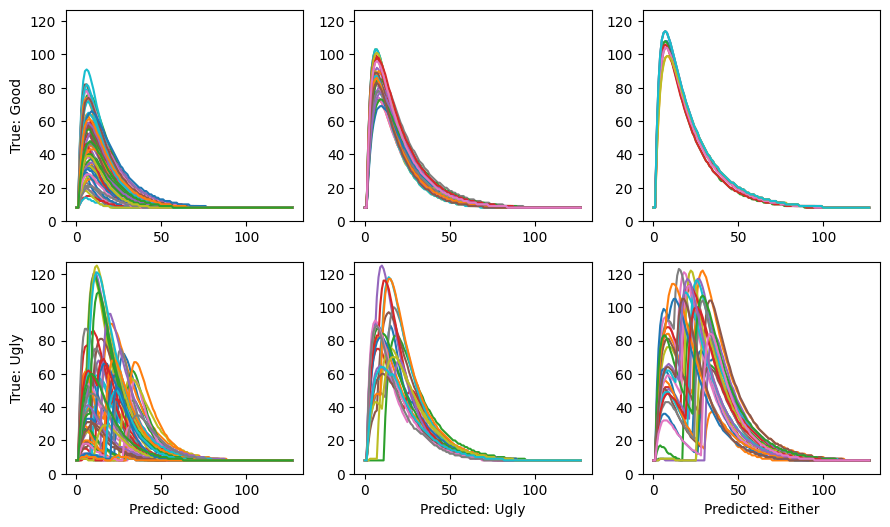

In [60]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(9, 6*0.9))

# Access with axes[row, col], e.g.:
# axes[0, 0].plot([1, 2, 3], [1, 4, 9])

max_plts = 100

cnt = 0
clplot = {0:[0,0], 1:[0,1], 2:[0,2]}
for i in zip(tuple_to_label(res_g[:max_plts]),Train_D_good[:max_plts]):
    # if i[0]==0:
        axes[*clplot[i[0]]].plot(i[1])
        # print(i[0])

clplot = {0:[1,0], 1:[1,1], 2:[1,2]}
for i in zip(tuple_to_label(res_b[:max_plts]),Train_D_bad[:max_plts]):
    # if np.sum(i[0])==1:
        axes[*clplot[i[0]]].plot(i[1])
        # print(i[0])

for i in range(2):
    for j in range(3):
        axes[i,j].set_ylim([0,127])

axes[0,0].set_ylabel("True: " + SiPM_lbl)
axes[1,0].set_ylabel("True: " + Nois_lbl)
# axes[1,0].set_title("Predicted: " + SiPM_lbl)
# axes[1,1].set_title("Predicted: " + Nois_lbl)
# axes[1,2].set_title("Predicted: Either")
axes[1,0].set_xlabel("Predicted: " + SiPM_lbl)
axes[1,1].set_xlabel("Predicted: " + Nois_lbl)
axes[1,2].set_xlabel("Predicted: Either")

plt.tight_layout()
plt.show()

# Write to VHDL file

In [61]:

# del hof

In [62]:
indi = None
if "hof" in globals():
    indi = hof[0]


In [63]:
if "hof" in globals():
    indi = hof[0]
else:
    indi = rand_indi()

NNwgth = conv_from_indi_to_wght(indi)
# NNbias = conv_from_indi_to_bias(indi)
NNsummap = conv_from_indi_to_summap(indi)

## Open/Overwrite file

In [64]:
VHD=open("../BNN_inst.vhd", "w")

In [65]:
inp_len, "input_width"

(7, 'input_width')

In [66]:
VHD_HEAD=f"""
library IEEE;
use IEEE.STD_LOGIC_1164.ALL;
use IEEE.NUMERIC_STD.ALL;

library work;
use work.BNN_pack.all;


entity BNN_forward is
    Port (
    input_i : in std_logic_vector({NN[0]}*input_width-1 downto 0);
    output_o : out std_logic_vector({NN[-1]}-1 downto 0)
    );
end BNN_forward;

architecture arch_imp of BNN_forward is
"""

VHD.write(VHD_HEAD)
print(VHD_HEAD)
# VHD.close()
# !cat BNN_inst.vhd


library IEEE;
use IEEE.STD_LOGIC_1164.ALL;
use IEEE.NUMERIC_STD.ALL;

library work;
use work.BNN_pack.all;


entity BNN_forward is
    Port (
    input_i : in std_logic_vector(128*input_width-1 downto 0);
    output_o : out std_logic_vector(2-1 downto 0)
    );
end BNN_forward;

architecture arch_imp of BNN_forward is



In [67]:
T=f"""
type t_NN_layout  is array (0 to {len(NN)}-1) of integer;
-- max index = width-1 
constant NN_width: t_NN_layout := ({", ".join([f"{i}-1" for i in NN])});
"""

VHD.write(T)
print(T)
# type t_sum_n3 is array (0 to NN_width(3) ) of neursum;
# signal sum_n3: t_sum_n3:= (others => (others => '0'));


# for L in list(range(len(NN)-1))+["f"]:
T=""




T+=f"type t_layer_n{0} is array (0 to NN_width({0}) ) of input_smpl;"
T+="\n"
T+=f"signal layer_n{0}: t_layer_n{0} := (others => (others => '0'));"
T+="\n"
T+="\n"


for L in range(1, len(NN)):
    T+=f"type t_sum_n{L} is array (0 to NN_width({L}) ) of neursum;"
    T+="\n"
    if True:
        T+=f"signal sum_n{L}: t_sum_n{L} := (others => (others => '0'));"
        T+="\n"
        T+=f"type t_layer_n{L} is array (0 to NN_width({L}) ) of neur;"
    T+="\n"
    T+=f"signal layer_n{L}: t_layer_n{L} := (others => (others => '0'));"
    T+="\n"
    # T+=f"type t_bias_n{L} is array (0 to NN_width({L}) ) of bias;"
    # T+="\n"

    T+="\n"


VHD.write(T)
print(T)

T="\n\n"
VHD.write(T)

for L in range(len(NN)-1):
    T+=f"type t_weight_n{L}_n{L+1} is array (0 to NN_width({L+1}) , 0 to NN_width({L}) ) of wght;"
    T+="\n"
VHD.write(T)
print(T)

T="\n\n"
VHD.write(T)


for L in range(1,len(NN)):
    T+=f"type t_summap_n{L} is array (0 to NN_width({L}) ) of neursum_map;"
    T+="\n"
VHD.write(T)
print(T)

T="\n\n"
VHD.write(T)





type t_NN_layout  is array (0 to 4-1) of integer;
-- max index = width-1 
constant NN_width: t_NN_layout := (128-1, 16-1, 128-1, 2-1);

type t_layer_n0 is array (0 to NN_width(0) ) of input_smpl;
signal layer_n0: t_layer_n0 := (others => (others => '0'));

type t_sum_n1 is array (0 to NN_width(1) ) of neursum;
signal sum_n1: t_sum_n1 := (others => (others => '0'));
type t_layer_n1 is array (0 to NN_width(1) ) of neur;
signal layer_n1: t_layer_n1 := (others => (others => '0'));

type t_sum_n2 is array (0 to NN_width(2) ) of neursum;
signal sum_n2: t_sum_n2 := (others => (others => '0'));
type t_layer_n2 is array (0 to NN_width(2) ) of neur;
signal layer_n2: t_layer_n2 := (others => (others => '0'));

type t_sum_n3 is array (0 to NN_width(3) ) of neursum;
signal sum_n3: t_sum_n3 := (others => (others => '0'));
type t_layer_n3 is array (0 to NN_width(3) ) of neur;
signal layer_n3: t_layer_n3 := (others => (others => '0'));




type t_weight_n0_n1 is array (0 to NN_width(1) , 0 to NN_widt

2

In [68]:

# T=""
# for L in range(1,len(NN)):
#     T += f"constant bias_n{L}: t_bias_n{L} := (\n"
#     ll = L
    
#     for i in range(NN[L]):
#         # T += f"b\"{NNbias[L][i*2]}{NNbias[L][i*2+1]}\""  +  ("," if i < NN[L]-1 else "\n")
#         T += f"b\"{np.binary_repr(NNbias[L-1][i],2)}\""  +  (", " if i < NN[L]-1 else "\n")
        
#     T += ");\n" 
#     # T += "\n"
# print(T)

# T+="\n\n"
# VHD.write(T)



In [69]:
NNwgth[0],NNwgth[1], NNwgth[0].ravel(), NN

(array([[0, 0, 0, ..., 2, 2, 3],
        [3, 1, 2, ..., 1, 0, 3],
        [3, 0, 2, ..., 2, 1, 2],
        ...,
        [1, 3, 1, ..., 1, 3, 2],
        [0, 0, 3, ..., 0, 0, 3],
        [1, 1, 2, ..., 2, 3, 0]], dtype=int8),
 array([[2, 3, 1, ..., 3, 3, 1],
        [3, 3, 2, ..., 3, 2, 3],
        [3, 2, 3, ..., 2, 3, 3],
        ...,
        [3, 3, 2, ..., 1, 1, 2],
        [3, 2, 0, ..., 1, 3, 2],
        [3, 3, 3, ..., 3, 3, 3]], dtype=int8),
 array([0, 0, 0, ..., 2, 3, 0], dtype=int8),
 array([128,  16, 128,   2]))

In [70]:
T=""
for L in range(len(NN)-1):
    T = f"constant weight_n{L}_n{L+1}: t_weight_n{L}_n{L+1} := (\n"
    VHD.write(T)
    print(T)
    ll = L
    
    for o in range(NN[ll+1]):
        T = "("
        for i in range(NN[ll]):
            w=np.binary_repr(NNwgth[ll][o][i],2)
            T += f"b\"{w}\"" +  (", " if i < NN[ll]-1 else ")\n")
            # T += f"'{(NNwgth[L].ravel()[i*(NN[ll+1]) +o]+1)//2}'"  +  ("," if o < NN[ll+1]-1 else ")\n")
            # T += f"b\"{np.binary_repr(NNwgth[ll].ravel()[o*(NN[ll+1]) +i],2)}\" {o,i,o*(NN[ll]) +i}"  +  (", " if i < NN[ll+1]-1 else ")\n")
            # T += f"'{(NNwgth[L].ravel()[i*(NN[ll+1]) +o]+1)//2}'"  +  ("," if o < NN[ll+1]-1 else ")\n")
        
        T += ("," if o < NN[ll+1]-1 else ");") + "\n" 
        VHD.write(T)
        print(T)

    T = "\n"
    print(T)
    VHD.write(T)




T="\n\n"
VHD.write(T)
print(T)



constant weight_n0_n1: t_weight_n0_n1 := (

(b"00", b"00", b"00", b"01", b"11", b"01", b"01", b"00", b"10", b"01", b"11", b"10", b"00", b"01", b"01", b"00", b"10", b"00", b"01", b"01", b"01", b"01", b"10", b"11", b"10", b"11", b"01", b"11", b"11", b"10", b"11", b"00", b"00", b"11", b"10", b"10", b"11", b"11", b"01", b"11", b"01", b"10", b"01", b"01", b"01", b"10", b"10", b"00", b"11", b"01", b"01", b"01", b"10", b"01", b"01", b"10", b"00", b"00", b"10", b"11", b"01", b"00", b"11", b"01", b"11", b"10", b"10", b"00", b"10", b"10", b"11", b"11", b"01", b"01", b"11", b"11", b"01", b"00", b"00", b"11", b"10", b"11", b"11", b"10", b"11", b"01", b"01", b"10", b"10", b"11", b"01", b"11", b"10", b"11", b"10", b"11", b"10", b"00", b"01", b"00", b"10", b"11", b"11", b"10", b"11", b"10", b"11", b"10", b"10", b"01", b"10", b"01", b"10", b"10", b"11", b"00", b"10", b"10", b"11", b"01", b"00", b"01", b"01", b"10", b"11", b"10", b"10", b"11")
,

(b"11", b"01", b"10", b"10", b"00", b"10", b"11", b"11",

In [71]:
NNsummap[0][0]

array([3213, 6426, 9639], dtype=uint32)

In [72]:
# t_summap_n1
T=""
for L in range(1,len(NN)):
    T += f"constant summap_n{L}: t_summap_n{L} := ( "
    # for o in range(NN[L]):
    T += ','.join( [  f"({ ','.join( map(str,s)) })"  for s in NNsummap[L-1]] )
    # T += f"{'),\n('.join( map(str,s )) }"
    # T += f"{-int(NN[L]/2)} , {int(NN[L]/2)} , {int(NN[L]*3/2)}"       
    # T += f"{int(NN[L]*3*1/4)} , {int(NN[L]*3*1/2)} , {int(NN[L]*3*3/4)}"       
    
    T += ");\n" 
print(T)

T+="\n\n"
VHD.write(T)

"""
constant summap_n1 : neursum_map := ( -128/2, 128/2 , 128*3/2 );
constant summap_n2 : neursum_map := ( -60/2, 60/2 , 60*3/2 );
constant summap_n3 : neursum_map := ( -24/2, 24/2 , 24*3/2 );
"""
1

constant summap_n1: t_summap_n1 := ( (3213,6426,9639),(3213,6426,9639),(3153,6307,9460),(3064,6128,9192),(3123,6247,9371),(3034,6069,9103),(3242,6485,9728),(3094,6188,9282),(3213,6426,9639),(3153,6307,9460),(2885,5771,8657),(3272,6545,9817),(3183,6366,9549),(3242,6485,9728),(2945,5890,8835),(3123,6247,9371));
constant summap_n2: t_summap_n2 := ( (7,22,37),(8,24,40),(8,24,40),(8,24,40),(8,24,40),(8,24,40),(8,24,40),(8,24,40),(7,22,37),(8,24,40),(8,24,40),(8,24,40),(8,24,40),(8,24,40),(7,22,37),(7,22,37),(8,24,40),(8,24,40),(8,24,40),(7,22,37),(8,24,40),(8,24,40),(7,22,37),(8,24,40),(8,24,40),(7,22,37),(7,22,37),(8,24,40),(8,24,40),(8,24,40),(8,24,40),(8,24,40),(7,22,37),(8,24,40),(7,22,37),(8,24,40),(8,24,40),(8,24,40),(8,24,40),(8,24,40),(7,21,35),(8,24,40),(7,21,35),(7,22,37),(8,24,40),(8,24,40),(7,22,37),(8,24,40),(7,21,35),(8,24,40),(7,22,37),(8,24,40),(8,24,40),(8,24,40),(8,24,40),(8,24,40),(8,24,40),(8,24,40),(8,24,40),(8,24,40),(8,24,40),(8,24,40),(8,24,40),(8,24,40),(8,24,40),(8

1

In [73]:
T="\nattribute KEEP : string;\n"
T += f"{"" if keep_l[0] else "-- "}attribute KEEP of layer_n{0} : signal is \"TRUE\";\n"
for L in range(1,len(NN)-1):
    T += f"{"" if keep_l[L] else "-- "}attribute KEEP of layer_n{L} : signal is \"TRUE\";\n"
T += f"{"" if keep_l[len(NN)-1] else "-- "}attribute KEEP of layer_n{len(NN)-1} : signal is \"TRUE\";\n"

print(T)

T+="\n\n"
VHD.write(T)




attribute KEEP : string;
-- attribute KEEP of layer_n0 : signal is "TRUE";
-- attribute KEEP of layer_n1 : signal is "TRUE";
-- attribute KEEP of layer_n2 : signal is "TRUE";
-- attribute KEEP of layer_n3 : signal is "TRUE";



228

In [74]:
T="\n\nbegin\n\n"
VHD.write(T)

9

In [75]:
T=""
for n in range(NN[0]):
    if False:
        T += f"layer_n0({n}) <= input_i({n});-- & not input_i({n});\n"
        T += f"layer_n0({n}) <= input_i({n}) & not input_i({n});\n"
    else:
        T += f"layer_n0({n}) <= unsigned(  input_i({(n+1)*inp_len}-1 downto {n*inp_len}) ) ;\n"

T+="\n\n"

for n in range(NN[-1]):
    # output_o(0) <= '1' when unsigned( layer_n3(0) ) > 1 else '0';
    # output_o(1) <= '1' when unsigned( layer_n3(1) ) > 1 else '0';
    T += f"output_o({n}) <= layer_n{len(NN)-1}({n})(1);\n"
    # T += f"output_o({n+1}) <= layer_n{len(NN)-1}({n})(1);\n"

print(T)

T+="\n\n"
VHD.write(T)


layer_n0(0) <= unsigned(  input_i(7-1 downto 0) ) ;
layer_n0(1) <= unsigned(  input_i(14-1 downto 7) ) ;
layer_n0(2) <= unsigned(  input_i(21-1 downto 14) ) ;
layer_n0(3) <= unsigned(  input_i(28-1 downto 21) ) ;
layer_n0(4) <= unsigned(  input_i(35-1 downto 28) ) ;
layer_n0(5) <= unsigned(  input_i(42-1 downto 35) ) ;
layer_n0(6) <= unsigned(  input_i(49-1 downto 42) ) ;
layer_n0(7) <= unsigned(  input_i(56-1 downto 49) ) ;
layer_n0(8) <= unsigned(  input_i(63-1 downto 56) ) ;
layer_n0(9) <= unsigned(  input_i(70-1 downto 63) ) ;
layer_n0(10) <= unsigned(  input_i(77-1 downto 70) ) ;
layer_n0(11) <= unsigned(  input_i(84-1 downto 77) ) ;
layer_n0(12) <= unsigned(  input_i(91-1 downto 84) ) ;
layer_n0(13) <= unsigned(  input_i(98-1 downto 91) ) ;
layer_n0(14) <= unsigned(  input_i(105-1 downto 98) ) ;
layer_n0(15) <= unsigned(  input_i(112-1 downto 105) ) ;
layer_n0(16) <= unsigned(  input_i(119-1 downto 112) ) ;
layer_n0(17) <= unsigned(  input_i(126-1 downto 119) ) ;
layer_n0(18) <= 

7348

### Main layer calc

In [76]:
L=0
T=""
T += f"calc_layer_n{L+1}:   for n{L+1} in 0 to NN_width({L+1}) generate\n"
T += f"sum_n{L+1}(n{L+1}) <= \n"
n2 = int( 2**np.ceil(np.log2(NN[L])) )
S=["" for i in range(n2+1)]
for i in range(n2+1):
    S[i] += "+"


for B in range( 1, int(np.log2(n2))+1 ):
    for i in range( int((n2+1)/(2**B))+1 ):
        S[i*(2**B)] = ")" + S[i*(2**B)] + "("
    
# print (S)

S[0] = S[0].split('+')[1]
S[-1] = S[-1].split('+')[0]
# print (S)


for i in range(NN[L]):
    T += f" {S[i]} \n inp_ws(layer_n{L}({i}),weight_n{L}_n{L+1}(n{L+1},{i})) \n"
for i in range(NN[L],n2):
    T += f" {S[i]} \n 0 \n"
T += f" {S[-1]};\n"
### nested sum with brackets


# T += f"layer_n{L+1}(n{L+1}) <= neur_b( neur_act( sum_n{L+1}(n{L+1}) , summap_n{L+1}), bias_n{L+1}(n{L+1}) );\nend generate;\n" 
T += f"layer_n{L+1}(n{L+1}) <= neur_act( sum_n{L+1}(n{L+1}) , summap_n{L+1}(n{L+1})) ;\nend generate;\n" 
T += "\n"
print(T)
VHD.write(T)


for L in range(1, len(NN)-1):
    T=""
    T += f"calc_layer_n{L+1}:   for n{L+1} in 0 to NN_width({L+1}) generate\n"
    T += f"sum_n{L+1}(n{L+1}) <= \n"
    n2 = int( 2**np.ceil(np.log2(NN[L])) )
    S=["" for i in range(n2+1)]
    for i in range(n2+1):
        S[i] += "+"
    
    
    for B in range( 1, int(np.log2(n2))+1 ):
        for i in range( int((n2+1)/(2**B))+1 ):
            S[i*(2**B)] = ")" + S[i*(2**B)] + "("
        
    # print (S)

    S[0] = S[0].split('+')[1]
    S[-1] = S[-1].split('+')[0]
    # print (S)

    
    # for i in range(NN[L]):
    #     T += f" {S[i]} \n {i} \n"
    # for i in range(NN[L],n2):
    #     T += f" {S[i]} \n {i}*0 \n"
    # T += f" {S[-1]}\n"
    # print(T)
    
    # break
    
    for i in range(NN[L]):
        T += f" {S[i]} \n neur_ws(layer_n{L}({i}),weight_n{L}_n{L+1}(n{L+1},{i})) \n"
    for i in range(NN[L],n2):
        T += f" {S[i]} \n 0 \n"
    T += f" {S[-1]};\n"
    ### nested sum with brackets


    # T += f"layer_n{L+1}(n{L+1}) <= neur_b( neur_act( sum_n{L+1}(n{L+1}) , summap_n{L+1}), bias_n{L+1}(n{L+1}) );\nend generate;\n" 
    T += f"layer_n{L+1}(n{L+1}) <= neur_act( sum_n{L+1}(n{L+1}) , summap_n{L+1}(n{L+1})) ;\nend generate;\n" 
    T += "\n"
    print(T)
    VHD.write(T)

T="\n\nend arch_imp;\n\n"
print(T)


VHD.write(T)




calc_layer_n1:   for n1 in 0 to NN_width(1) generate
sum_n1(n1) <= 
 ((((((( 
 inp_ws(layer_n0(0),weight_n0_n1(n1,0)) 
 + 
 inp_ws(layer_n0(1),weight_n0_n1(n1,1)) 
 )+( 
 inp_ws(layer_n0(2),weight_n0_n1(n1,2)) 
 + 
 inp_ws(layer_n0(3),weight_n0_n1(n1,3)) 
 ))+(( 
 inp_ws(layer_n0(4),weight_n0_n1(n1,4)) 
 + 
 inp_ws(layer_n0(5),weight_n0_n1(n1,5)) 
 )+( 
 inp_ws(layer_n0(6),weight_n0_n1(n1,6)) 
 + 
 inp_ws(layer_n0(7),weight_n0_n1(n1,7)) 
 )))+((( 
 inp_ws(layer_n0(8),weight_n0_n1(n1,8)) 
 + 
 inp_ws(layer_n0(9),weight_n0_n1(n1,9)) 
 )+( 
 inp_ws(layer_n0(10),weight_n0_n1(n1,10)) 
 + 
 inp_ws(layer_n0(11),weight_n0_n1(n1,11)) 
 ))+(( 
 inp_ws(layer_n0(12),weight_n0_n1(n1,12)) 
 + 
 inp_ws(layer_n0(13),weight_n0_n1(n1,13)) 
 )+( 
 inp_ws(layer_n0(14),weight_n0_n1(n1,14)) 
 + 
 inp_ws(layer_n0(15),weight_n0_n1(n1,15)) 
 ))))+(((( 
 inp_ws(layer_n0(16),weight_n0_n1(n1,16)) 
 + 
 inp_ws(layer_n0(17),weight_n0_n1(n1,17)) 
 )+( 
 inp_ws(layer_n0(18),weight_n0_n1(n1,18)) 
 + 
 inp_ws(layer_n0(

17

In [77]:
# neur_ws(layer_n0(0),weight_n0_n1(0,n1)) 

In [78]:
VHD.close()


## Finished VHDL

# End

## Testbench Prep

In [79]:
import numpy as np

arr = np.random.randint(0, 128, size=128)

def wf_to_vhdl(arr):
    # Concatenate into one big binary string, MSB of each element first
    bitstring = "".join(f"{val:07b}" for val in arr[::-1])
    
    # Wrap to 80 chars per line for readability in VHDL
    lines = [bitstring[i:i+7*8] for i in range(0, len(bitstring), 7*8)]
    vhdl_str = "constant stimulus : std_logic_vector(895 downto 0) :=\n"
    vhdl_str += " &\n".join(f'  "{line}"' for line in lines) + ";"
    print(arr)
    print(vhdl_str)



In [80]:
a = SiPM_inp()
wf_to_vhdl( a )


[8 8 8 9 9 9 9 9 9 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8
 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8 8]
constant stimulus : std_logic_vector(895 downto 0) :=
  "00010000001000000100000010000001000000100000010000001000" &
  "00010000001000000100000010000001000000100000010000001000" &
  "00010000001000000100000010000001000000100000010000001000" &
  "00010000001000000100000010000001000000100000010000001000" &
  "00010000001000000100000010000001000000100000010000001000" &
  "00010000001000000100000010000001000000100000010000001000" &
  "00010000001000000100000010000001000000100000010000001000" &
  "00010000001000000100000010000001000000100000010000001000" &
  "00010000001000000100000010000001000000100000010000001000" &
  "00010000001000000100000010000001000000100000010000001000" &
  "0001000000100000010000001000000100000010000001000000

In [81]:
conv_from_indi_to_wght(indi)[0]

array([[0, 0, 0, ..., 2, 2, 3],
       [3, 1, 2, ..., 1, 0, 3],
       [3, 0, 2, ..., 2, 1, 2],
       ...,
       [1, 3, 1, ..., 1, 3, 2],
       [0, 0, 3, ..., 0, 0, 3],
       [1, 1, 2, ..., 2, 3, 0]], dtype=int8)

In [82]:
a = [8,8,22,32,38,42,45,46,46,45,44,42,41,39,37,35,33,32,30,28,27,25,24,23,21,20,19,18,18,17,16,15,15,14,14,13,13,12,12,11,11,11,11,10,10,10,10,10,9,9,9,9,9,9,9,9,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8,8]
a = np.asarray(a)

In [83]:
verbose = True
# run_NN_from_indi([a], indi)



def run_NN_verbose(inp, pars):
    global NN
    # NN, NNwgth, NNbias, NNsummap = pars
    NNwgth,NNsummap  = pars
    layer_ni = inp #layer_inp(inp)
    print(layer_ni)
    for i in range(0,len(NN)-1):
        layer_ni = calc_layer( layer_ni, i, NNwgth,  NNsummap)
        print(layer_ni)
    return output_o(layer_ni)

# run_NN(rand_inp(NN[0]), pars=(NNwgth,NNsummap)), \
verbose = True
# run_NN(rand_inp(NN[0]), pars=(NNwgth,conv_from_indi_to_summap(rand_indi()) )), \
run_NN_verbose(a, pars=(conv_from_indi_to_wght(indi),conv_from_indi_to_summap(indi) ))


[ 8  8 22 32 38 42 45 46 46 45 44 42 41 39 37 35 33 32 30 28 27 25 24 23
 21 20 19 18 18 17 16 15 15 14 14 13 13 12 12 11 11 11 11 10 10 10 10 10
  9  9  9  9  9  9  9  9  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8]
[1 1 1 1 2 1 2 2 1 1 1 1 2 1 2 1]
[2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 1 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2]
[2 1]


array([1, 0], dtype=uint8)

In [84]:
a = Nois_inp()
wf_to_vhdl( a )


run_NN_verbose(a, pars=(conv_from_indi_to_wght(indi),conv_from_indi_to_summap(indi) ))


[ 8  8  8  9  9  9  9  9  9  9  8  8  9 10 10 10 10 10 10 10  9  9  9  9
  9  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8  8
  8  8  8  8  8  8  8  8]
constant stimulus : std_logic_vector(895 downto 0) :=
  "00010000001000000100000010000001000000100000010000001000" &
  "00010000001000000100000010000001000000100000010000001000" &
  "00010000001000000100000010000001000000100000010000001000" &
  "00010000001000000100000010000001000000100000010000001000" &
  "00010000001000000100000010000001000000100000010000001000" &
  "00010000001000000100000010000001000000100000010000001000" &
  "00010000001000000100000010000001000000100000010000001000" &
  "00010000001000000100000010000001000000100000010000001000" &
  "000100000010000001000000100000010000001000000100

array([1, 0], dtype=uint8)

## HDL snippets

In [85]:
import numpy as np

In [86]:
## Outdated
# BNN_val = { 
#     -1: "10" ,
#      0: "00" ,
#      1: "01" ,
#      2: "11" ,
# }    
BNN_val = { 
     0: "00" ,
     1: "01" ,
     2: "10" ,
     3: "11" ,
}    
BNN_val[1]

'01'

In [87]:
## Outdated
"""
# Bias
n + 00 => 00
n + 01 => n-1
n + 02 => n
n + 03 => n+1
"""


'\n# Bias\nn + 00 => 00\nn + 01 => n-1\nn + 02 => n\nn + 03 => n+1\n'

In [88]:
## Outdated
def BNN_plus(a,b):
    plus_d = {
        frozenset({-1} ) : -1,
        frozenset({0} )  :  0,
        frozenset({1} )  :  1,
        frozenset({2} )  :  2,
        frozenset({-1,0} ) : -1,
        frozenset({-1,1} ) : 0,
        frozenset({-1,2} ) : 0,
        frozenset({0,1} )  :  1,
        frozenset({0,2} )  :  1,
        frozenset({1,2} )  :  2,    
    }
    return plus_d[frozenset({a,b} )]


def BNN_plus(a,b):
    plus_d = {
        frozenset({0} )    :  0,
        frozenset({1} )    :  1,
        frozenset({2} )    :  2,
        frozenset({3} )    :  3,
        frozenset({0,1} )  :  0,
        frozenset({0,2} )  :  1,
        frozenset({0,3} )  :  1,
        frozenset({1,2} )  :  2,
        frozenset({1,3} )  :  2,
        frozenset({2,3} )  :  3,    
    }
    return plus_d[frozenset({a,b} )]

BNN_plus(1,2)



2

In [89]:
## Outdated

a = [-1,0,1,2]
a = [0,1,2,3]
# comb = []
for i in a:
    for o in a:
        # comb.append( frozenset([i,o]) )
        print("{: 2d}".format( BNN_plus(i,o) ), end="")
    print()
# frozenset(comb)

for i in a:
    for o in a:
        print(' when "{:s}{:s}" => res := "{:s}";'.format( BNN_val[i], BNN_val[o], BNN_val[BNN_plus(i,o)] ) )


 0 0 1 1
 0 1 2 2
 1 2 2 3
 1 2 3 3
 when "0000" => res := "00";
 when "0001" => res := "00";
 when "0010" => res := "01";
 when "0011" => res := "01";
 when "0100" => res := "00";
 when "0101" => res := "01";
 when "0110" => res := "10";
 when "0111" => res := "10";
 when "1000" => res := "01";
 when "1001" => res := "10";
 when "1010" => res := "10";
 when "1011" => res := "11";
 when "1100" => res := "01";
 when "1101" => res := "10";
 when "1110" => res := "11";
 when "1111" => res := "11";
